In [1]:
!pip install zarr
!pip install alphashape
!pip install dionysus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 62.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=3dc964d9f5ef3952ebbb8d58f76c282bf369aa78b9bae1692deb1f44118fee3f
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.5/682.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=413794 sha256=b8ee0297042a753b19d650dc174a5346b831727539b9145742925f6551b37f31
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f6

In [2]:
import networkx as nx
import scipy.spatial as sp
import zarr
import matplotlib.pyplot as plt
import numpy as np
import alphashape
from shapely.geometry import Polygon, mapping
import dionysus as d

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/NASA/Fire Detection")
!ls -ltr

Mounted at /content/drive
total 12
drwx------ 2 root root 4096 Jun  6 00:50 'zzpd fire data'
drwx------ 2 root root 4096 Jun  9 01:01 'zzpd fire data 2'
drwx------ 2 root root 4096 Jul  6 01:45 'zzpd fire data 3'


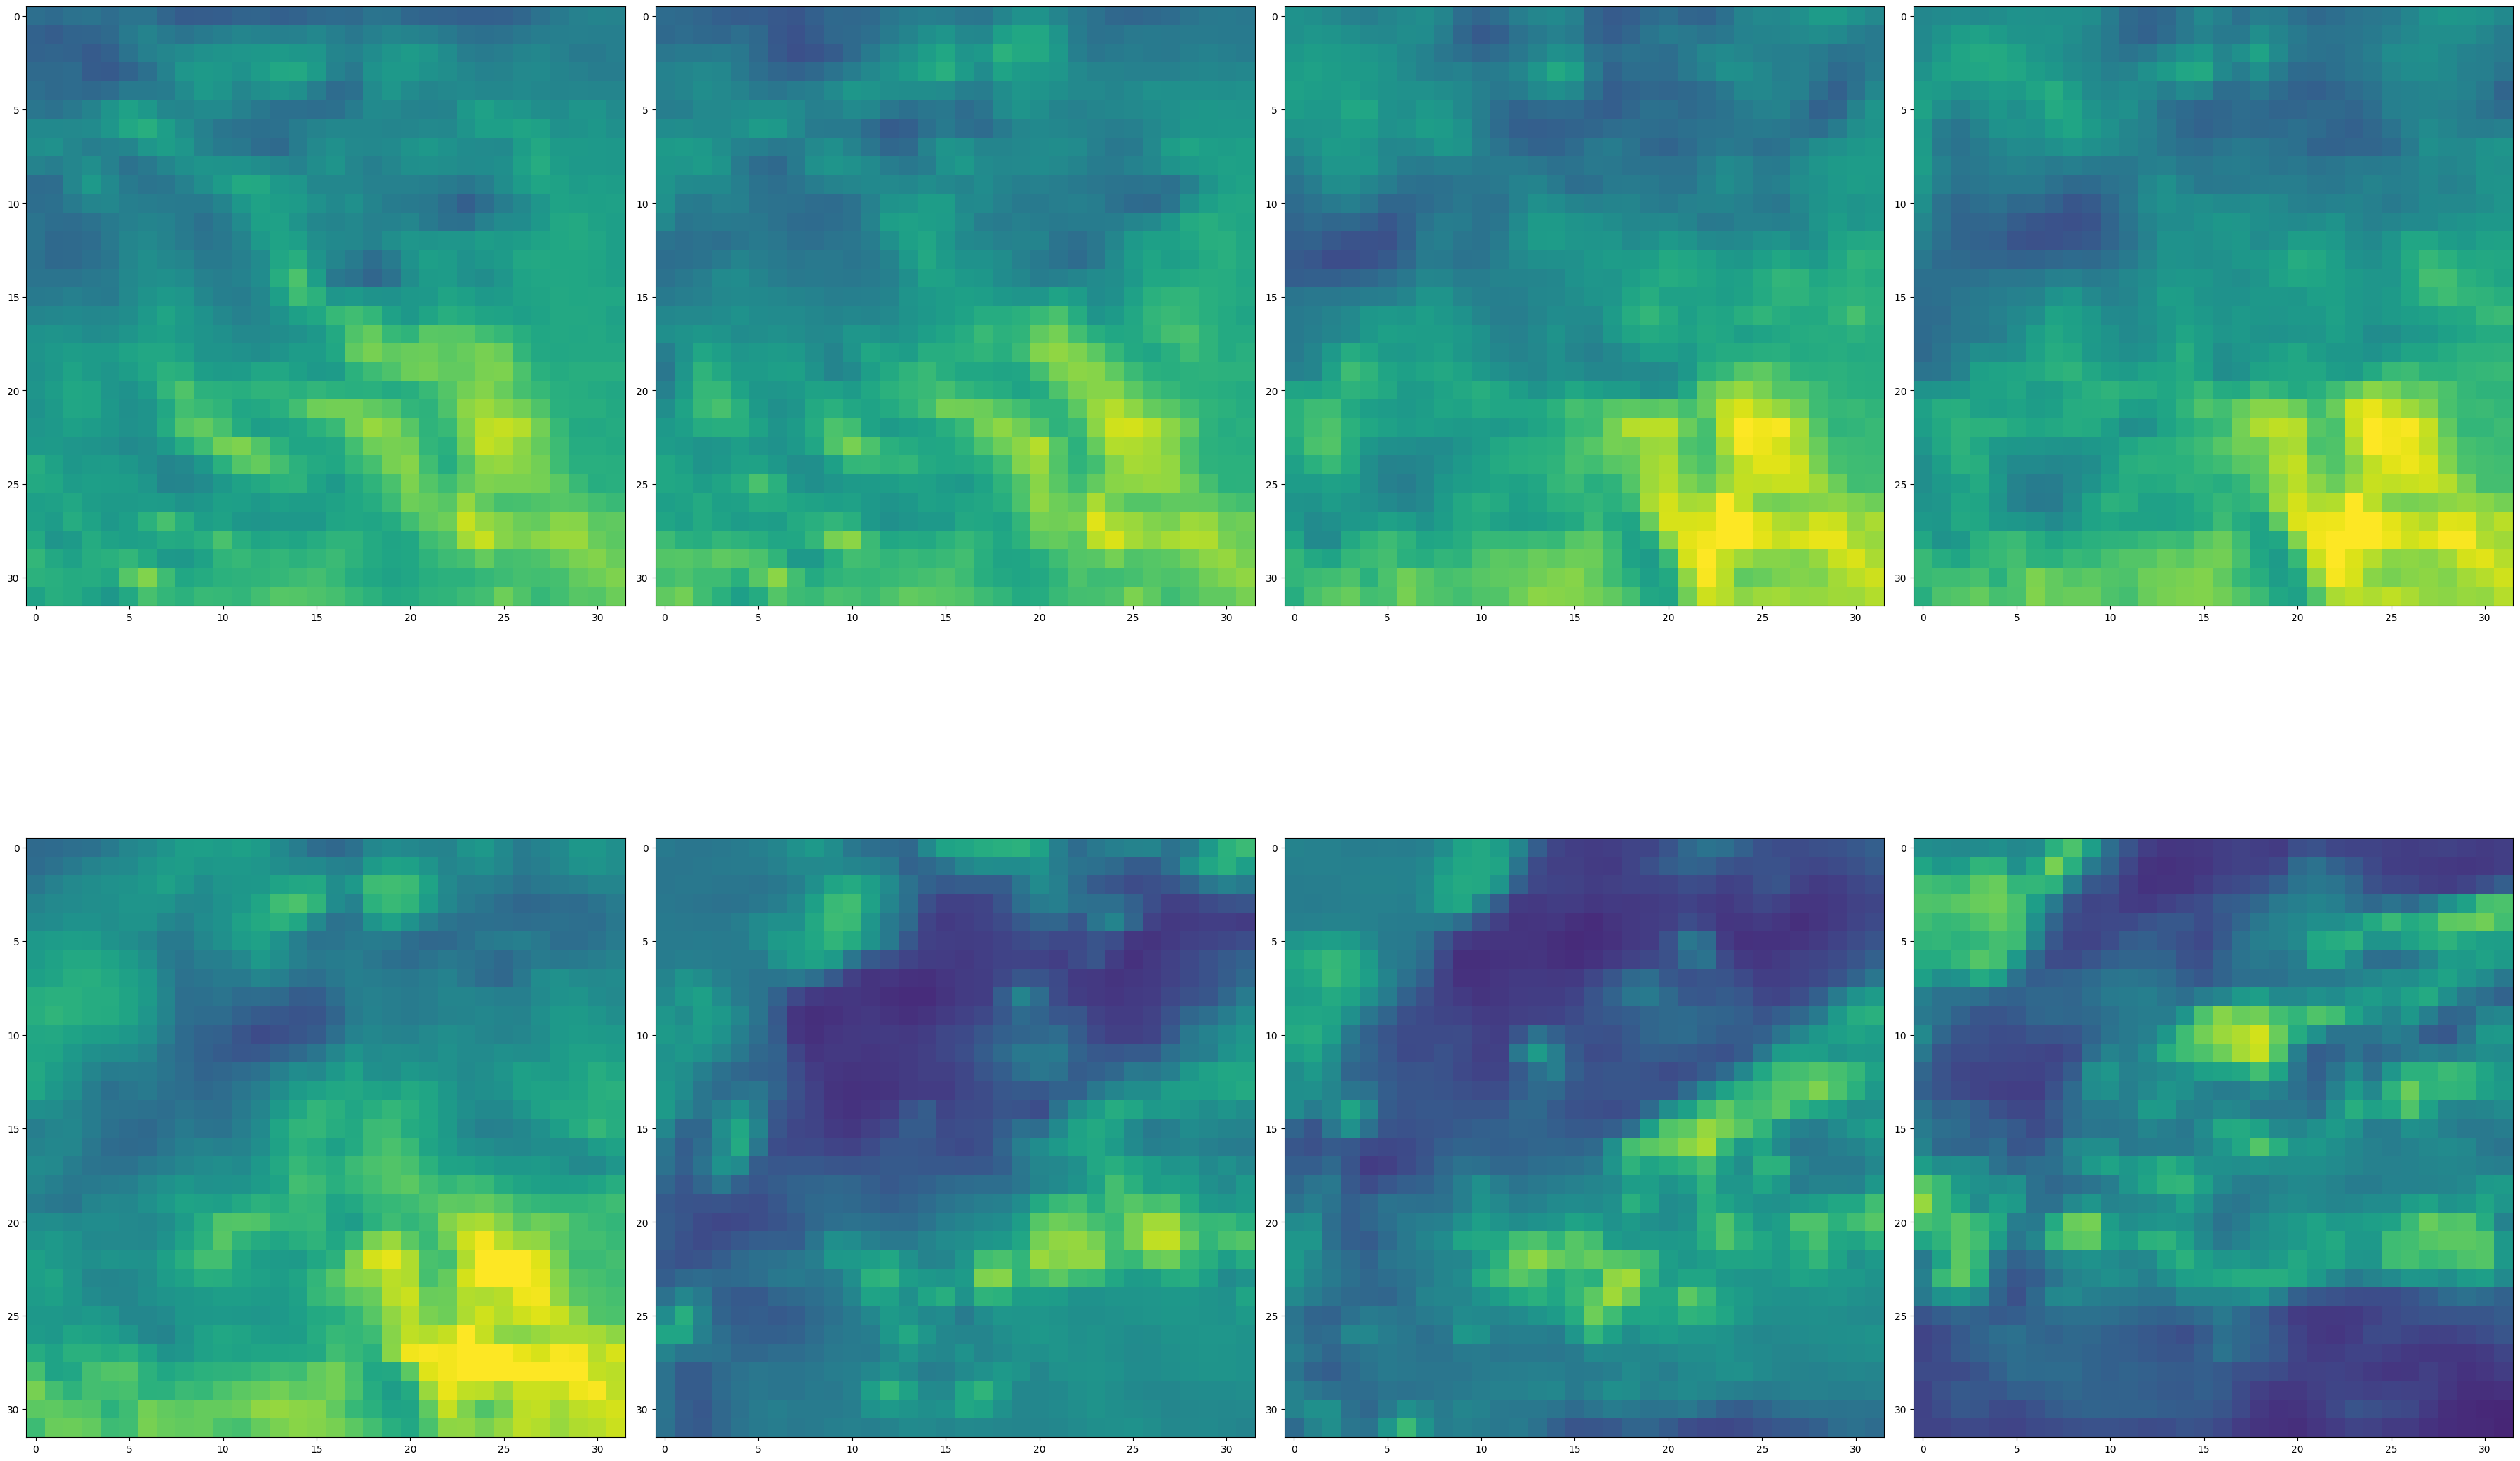

In [4]:
fname = 'zzpd fire data 2'
rawFileList = os.listdir(fname)

channel7List = []
channel7Name = []
timeSeriesDict = {}

rawFileList = sorted(rawFileList)

for name in rawFileList:
    channelData = np.array(zarr.open(fname + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)

nrow = 2 # old data
ncol = 4

fig, axs = plt.subplots(nrow, ncol, figsize=(36, 27))

for i in range(nrow):
    for j in range(ncol):
        axs[i, j].imshow(channel7List[i* ncol + j], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        #label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j], 'fire'].iloc[0]
        #axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

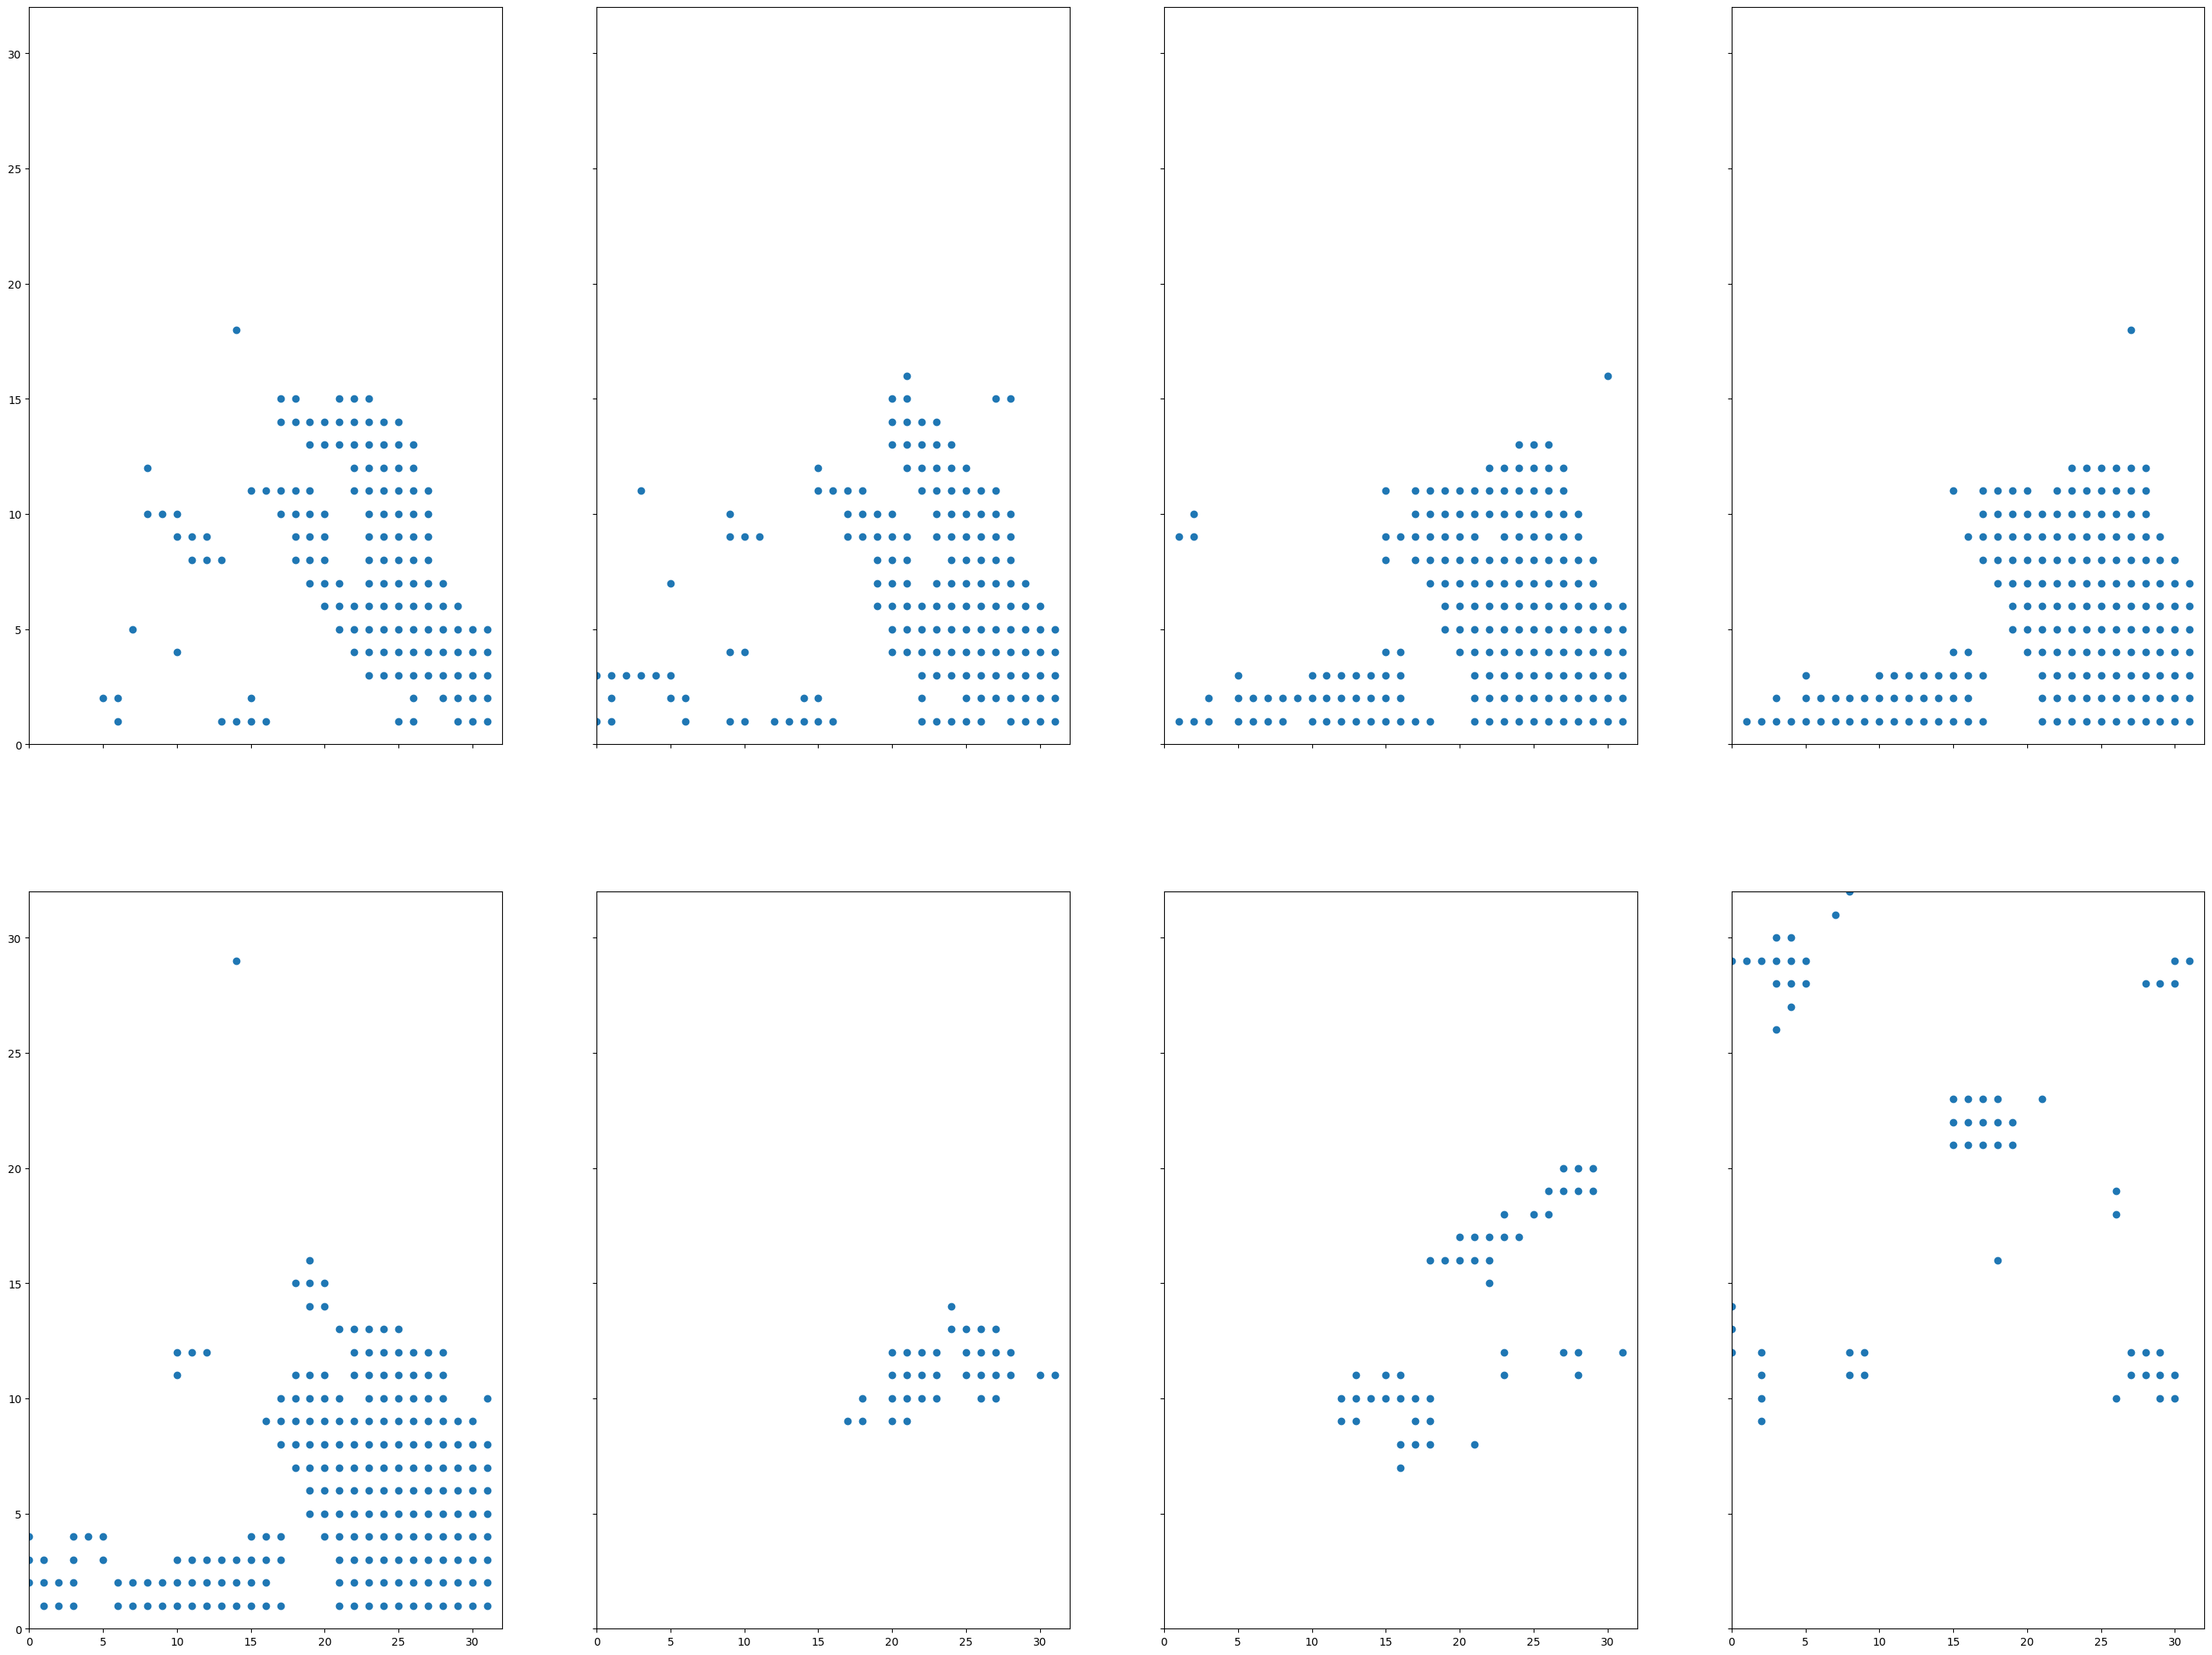

In [5]:
subLevel = 0.7

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(36, 27))
for i in range(0, nrow):
    for j in range(0, ncol):
        pointcloud = np.argwhere(np.array(channel7List[i*ncol + j]) > subLevel)
        x = pointcloud[:, 1]
        y = 32 - pointcloud[:, 0]
        ax[i, j].scatter(x, y)
        ax[i, j].set_xlim([0, 32])
        ax[i, j].set_ylim([0, 32])
plt.show()

In [6]:
testData = np.argwhere(np.array(channel7List[7]) > subLevel)
l = []
for i in list(testData):
    l.append(list(i))

print (l)

[[0, 8], [1, 7], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 30], [3, 31], [4, 3], [4, 4], [4, 5], [4, 28], [4, 29], [4, 30], [5, 4], [6, 3], [9, 15], [9, 16], [9, 17], [9, 18], [9, 21], [10, 15], [10, 16], [10, 17], [10, 18], [10, 19], [11, 15], [11, 16], [11, 17], [11, 18], [11, 19], [13, 26], [14, 26], [16, 18], [18, 0], [19, 0], [20, 0], [20, 2], [20, 8], [20, 9], [20, 27], [20, 28], [20, 29], [21, 2], [21, 8], [21, 9], [21, 27], [21, 28], [21, 29], [21, 30], [22, 2], [22, 26], [22, 29], [22, 30], [23, 2]]


In [7]:
def getAlphaExt(pointcloud): # pointcloud defined as list of points in R^2
    nodelst = pointcloud
    G = nx.Graph()
    G.add_edges_from( sp.cKDTree(nodelst).query_pairs(r=1) )

    groupList = []
    for x in nx.connected_components(G):
        groupList.append(list(x))

    regionDict = {}
    R_alpha_dict = {}
    shapeCount = 0
    for i in range(len(groupList)):
        regionDict['group{}'.format(i)] = np.array([nodelst[j] for j in groupList[i]])
        regionDict['group{}'.format(i)][:, 0] = 32 - regionDict['group{}'.format(i)][:, 0]

        if len(regionDict['group{}'.format(i)]) > 2:
            alpha_shape = alphashape.alphashape(regionDict['group{}'.format(i)], 1) # set alpha = 1
            if alpha_shape.geom_type=='Polygon':
                xx, yy = alpha_shape.exterior.coords.xy
                R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                shapeCount += 1

            if alpha_shape.geom_type=='MultiPolygon':
                for ea in alpha_shape.geoms:
                    xx, yy = ea.exterior.coords.xy
                    R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                    shapeCount += 1

    P_alpha_list = []
    region_length_list = []
    for i in range(len(R_alpha_dict)):
        # print (len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
        P_alpha_list = P_alpha_list + list(set(R_alpha_dict['RAlpha{}'.format(i)]))
        region_length_list.append(len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
    P_alpha = np.array(P_alpha_list)

    return P_alpha.tolist(), region_length_list

In [8]:
P_alpha, region_length_list = getAlphaExt(l)
print (len(P_alpha))
print (region_length_list)

QhullError: ignored

In [ ]:
nodelst = l
G = nx.Graph()
G.add_edges_from( sp.cKDTree(nodelst).query_pairs(r=1) )

groupList = []
for x in nx.connected_components(G):
    groupList.append(list(x))
    print (x)

In [ ]:
regionDict = {}
R_alpha_dict = {}

shapeCount = 0
for i in range(len(groupList)):
    regionDict['group{}'.format(i)] = np.array([nodelst[j] for j in groupList[i]])
    regionDict['group{}'.format(i)][:, 0] = 32 - regionDict['group{}'.format(i)][:, 0]

    if len(regionDict['group{}'.format(i)]) > 2:
        alpha_shape = alphashape.alphashape(regionDict['group{}'.format(i)], 1) # set alpha = 1
        if alpha_shape.geom_type=='Polygon':
            xx, yy = alpha_shape.exterior.coords.xy
            R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
            shapeCount += 1
            plt.plot(yy,xx)
        if alpha_shape.geom_type=='MultiPolygon':
            for ea in alpha_shape.geoms:
                xx, yy = ea.exterior.coords.xy
                R_alpha_dict['RAlpha{}'.format(shapeCount)] = list(zip(xx, yy))
                shapeCount += 1
                plt.plot(yy,xx)

    x = regionDict['group{}'.format(i)][:, 1]
    y = regionDict['group{}'.format(i)][:, 0]
    plt.scatter(x, y)

P_alpha_list = []
region_length_list = []
for i in range(len(R_alpha_dict)):
    # print (len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
    P_alpha_list = P_alpha_list + list(set(R_alpha_dict['RAlpha{}'.format(i)]))
    region_length_list.append(len(list(set(R_alpha_dict['RAlpha{}'.format(i)]))))
P_alpha = np.array(P_alpha_list)
print (len(P_alpha))
print (region_length_list)
print (P_alpha.tolist())
plt.xlim([0, 32])
plt.ylim([0, 32])
plt.figure(figsize=(15,12))
plt.show()

In [ ]:
points = [i for i in range(len(P_alpha))]
print (len(P_alpha))
region_length_list.insert(0, 0)
print (np.cumsum(region_length_list))
stamp = np.cumsum(region_length_list)


region0 = points[stamp[0]:stamp[1]]
region0.append(region0[0])
region1 = points[stamp[1]:stamp[2]]
region1.append(region1[0])
region2 = points[stamp[2]:stamp[3]]
region2.append(region2[0])
region3 = points[stamp[3]:stamp[4]]
region3.append(region3[0])

region3_simp = []
for i in range(len(region3)):
    region3_simp.append([region3[i]])
    if i != len(region3) - 1:
        region3_simp.append([region3[i], region3[i+1]])

print (points)
print (region0)
print (region1)
print (region2)
print (region3)

print (region3_simp)

In [ ]:
def getAlphaShapeComplex(pointCloud, regionLengthList): #input R_alpha
    points = [i for i in range(len(pointCloud))]
    tempLengthList = [0] + regionLengthList
    stamp = np.cumsum(tempLengthList)

    tempDict = {}
    simpDict = {}
    for i in range(len(tempLengthList) - 1):
        tempDict['region{}'.format(i)] = points[stamp[i]:stamp[i+1]]
        tempDict['region{}'.format(i)].append(tempDict['region{}'.format(i)][0])

        simpDict['region{}_simp'.format(i)] = []
        for j in range(len(tempDict['region{}'.format(i)])):
            #simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
            if j != len(tempDict['region{}'.format(i)]) - 1:
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j]])
                simpDict['region{}_simp'.format(i)].append([tempDict['region{}'.format(i)][j], tempDict['region{}'.format(i)][j+1]])

    f = d.Filtration()
    for i in range(len(simpDict)):
        for vertices in simpDict['region{}_simp'.format(i)]:
            f.append(d.Simplex(vertices))

    return f

In [ ]:
f = getAlphaShapeComplex(P_alpha, region_length_list)
#for s in f:
#    print (s)
print (type(f))

In [ ]:
points = np.random.random((3, 2))
f = d.fill_rips(points, 2, 1)

for i in f:
    i.data = 0.0

for i in f:
    print (i)

#simps_list = []
#simps_list = simps_list + [s for s in f]

#print (simps_list)
#print (type(f))

In [ ]:
#print (groupList)
s1 = d.Simplex([0])
s2 = d.Simplex([1])
s3 = d.Simplex([0, 1])
simps_list = [s1, s2, s3]
print (simps_list)

for group in groupList:
    print (group)


In [ ]:
simplices = [[0], [1], [0,1], [2], [1,2], [0,2]]
f = d.Filtration()
for vertices in simplices:
    f.append(d.Simplex(vertices))
#f.sort(dim_data_cmp)
for s in f:
    s.data = 5

for s in f:
    print (s)

In [ ]:
test = [1,1,2,3,3,5]
print (list(set(test)))

In [11]:
from numpy.linalg import matrix_rank

def are_collinear(coords, tol=None):
    return matrix_rank(coords, tol=tol)==1

a = np.array([[0, 0],
              [0, 1],
              [0, 2],
              [1, 3]])

print (are_collinear(a))

False
